In [1]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata
from datetime import date, datetime 
import time

import utils
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
from config import date_key, data_dir, store_dir

In [3]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )

In [4]:
md = utils.make_metadata_dict(dss, results, fdrcutoff=0.05)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

# Helper functions

In [5]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

def apd(results, fdr_cutoff=0.05):
    n_anno = []
    for tab in results.values():
        if tab[tab['fdr'] <= fdr_cutoff].shape[0] >0:
            n_anno.append(tab[tab['fdr'] <= fdr_cutoff].shape[0])
            
    return n_anno

def dpa(results, fdr_cutoff=0.05):
    dpad = defaultdict(int)
    for tab in results.values():
        tmp = list(tab[tab['fdr'] <= fdr_cutoff].index)
        for t in tmp:
            dpad[t] += 1
    return dpad

# Figure 1

In [6]:
# For complete Figure, this might be helpful:
# https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot

## Submissions

In [7]:
all_ds_ids = pd.read_csv(os.path.join(data_dir, 'all_dataset_ids-06-09-23.csv'), header=None)
all_ds_ids[0] = all_ds_ids[0].apply(lambda x: toYearFraction(date.fromisoformat(x.split('_')[0])))
all_ds_ids['Datasets'] = 'All'
all_ds_ids = all_ds_ids.rename(columns={0:'Date'})
all_ds_ids = all_ds_ids.sort_values('Date')
all_ds_ids['Submissions'] = np.arange(all_ds_ids.shape[0])

In [8]:
sm = SMInstance()
new_datasets = sm.datasets()

In [9]:
public_ids = pd.DataFrame({'Date': [toYearFraction(date.fromisoformat(x.id.split('_')[0])) for x in new_datasets]})
public_ids = public_ids[public_ids['Date'] <= all_ds_ids['Date'].max()]
public_ids['Datasets'] = 'Public'
public_ids = public_ids.sort_values('Date')
public_ids['Submissions'] = np.arange(public_ids.shape[0])

<AxesSubplot: xlabel='Date', ylabel='Submissions'>

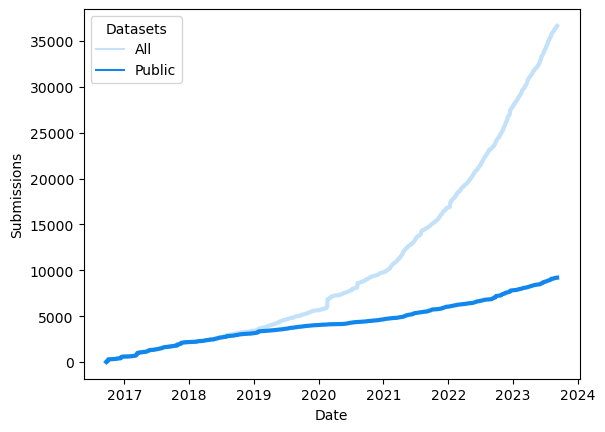

In [10]:
sns.lineplot(data=pd.concat([all_ds_ids, public_ids]), x='Date', y='Submissions', hue='Datasets', palette={'Public': '#1187ee', 'All': '#c3e2f9ff'}, lw=3)

## Contributors

/tmp/ipykernel_1074/1280037718.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabs)


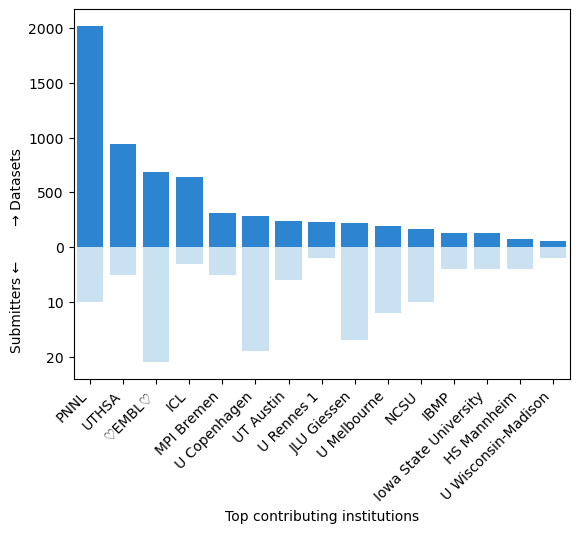

In [11]:
grp = []
sbmttr = []

submitter_scaling = 50

for ds in dss:
    if not (ds.group is None or ds.submitter is None):
        grp.append(ds.group['shortName'])
        sbmttr.append(ds.submitter['id'])

labs = pd.DataFrame({'Lab': grp, 'Submitter': sbmttr})
#labs.groupby('Lab').nunique()
labs = labs.groupby('Lab').agg('count').rename(columns={'Submitter': 'Datasets'}).join(labs.groupby('Lab').nunique())
labs['Submitter'] = - labs['Submitter'] * submitter_scaling
labs = labs.sort_values('Datasets', ascending=False).reset_index()
labs = labs[:15]

ax = sns.barplot(data=labs, x='Lab', y='Datasets', color='#1187ee')
sns.barplot(data=labs, x='Lab', y='Submitter', color='#c3e2f9ff', ax=ax)

# Replace negative values for to number of submitters
ylabs = ax.get_yticklabels()
for yticklabel in ylabs:
    label = int(yticklabel.get_text().replace('−', '-'))
    if label < 0:
        yticklabel.set_text(int(label/(-submitter_scaling)))
ax.set_yticklabels(ylabs)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
ax.set_ylabel('Submitters ←        → Datasets')
ax.set_xlabel('Top contributing institutions')
ax.yaxis.set_label_coords(-0.1, .35)
plt.show()

## Organisms/Organs

In [12]:
org_org = mdt[['Organism', 'Organism_Part']].rename(columns={'Organism_Part': 'Organ'}).reset_index()  # .groupby(['Organism', 'Organ']).agg('count')
most_organs = list(org_org.groupby('Organ').agg('count').sort_values('Organism', ascending=False).index[:10])
most_organisms = list(org_org.groupby('Organism').agg('count').sort_values('Organ', ascending=False).index[:3])

most_organisms = [x for x in most_organisms if x not in ['N/A', 'Multiple']]

org_org = org_org[org_org['Organism'].isin(most_organisms)]
org_org = org_org[org_org['Organ'].isin(most_organs)]


org_org2 = org_org.groupby(['Organism', 'Organ']).agg('count').reset_index()

/tmp/ipykernel_1074/2543418007.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  main_ax.set_xticklabels(main_ax.get_xticklabels(), rotation = 45, ha="right")


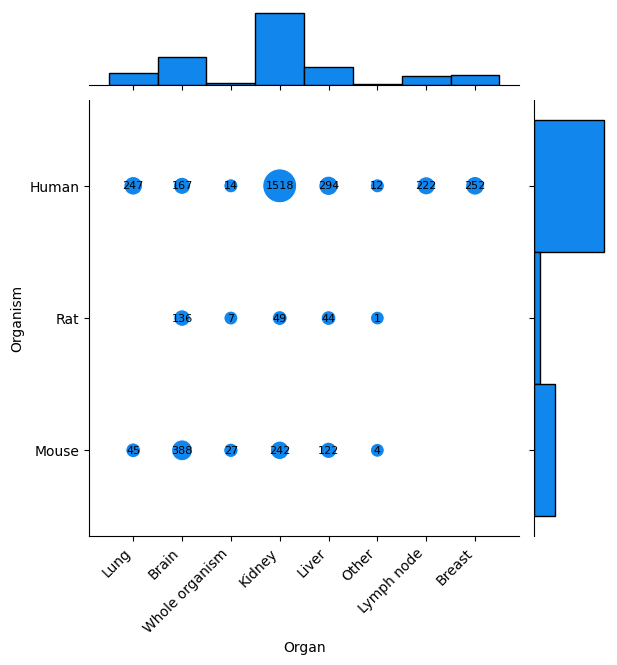

In [13]:
g = sns.JointGrid(data=org_org, y='Organism', x='Organ')
g.plot_joint(sns.scatterplot, s=100, alpha=.5, color='white')
g.plot_marginals(sns.histplot, color='#1187ee', alpha = 1)

main_ax = g.ax_joint
main_ax.set_xticklabels(main_ax.get_xticklabels(), rotation = 45, ha="right")

sns.scatterplot(data=org_org2, y='Organism', x='Organ', size='index', ax=main_ax, sizes=(100, 600), color='#1187ee', legend=False)

for i in range(org_org2.shape[0]):
            main_ax.text(org_org2.loc[i, :]['Organ'], org_org2.loc[i, :]['Organism'], org_org2.loc[i, :]['index'], 
                         ha="center", va="center", fontdict={'fontsize': 8})
    

## Technologies

Text(0, 0.5, 'Datasets')

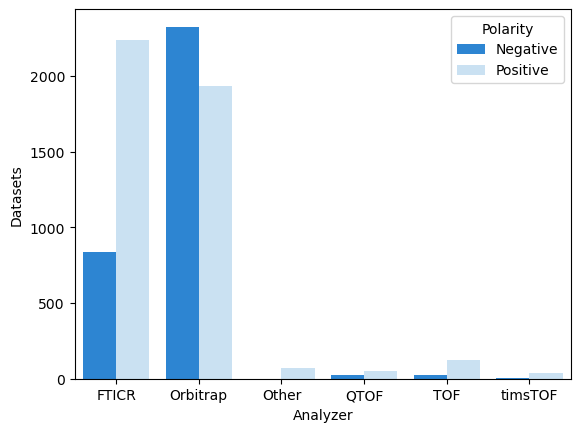

In [14]:
tmp = mdt.groupby(['Polarity', 'Analyzer']).agg('count').reset_index()

ax = sns.barplot(data=tmp, x='Analyzer', y='Condition', hue='Polarity', palette={'Negative': '#1187ee', 'Positive': '#c3e2f9ff'})
ax.set_ylabel('Datasets')

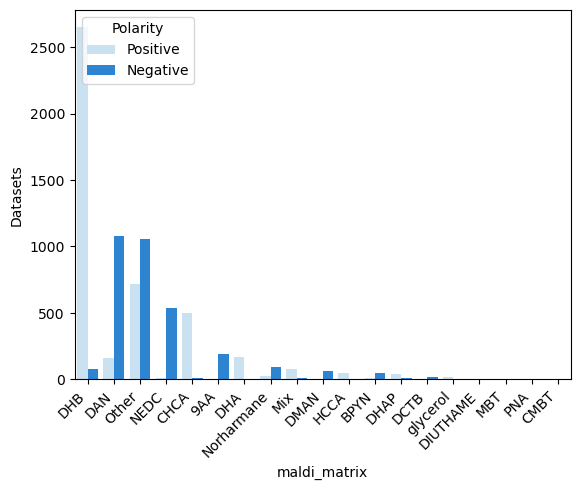

In [15]:
tmp = mdt.groupby(['Polarity', 'maldi_matrix']).agg('count').reset_index().sort_values('Organism', ascending=False)

ax = sns.barplot(data=tmp, x='maldi_matrix', y='Condition', hue='Polarity', palette={'Negative': '#1187ee', 'Positive': '#c3e2f9ff'})
ax.set_ylabel('Datasets')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
plt.show()

## Annotations per dataset

Text(0.5, 0, '$log_{10}$ Annotations per dataset')

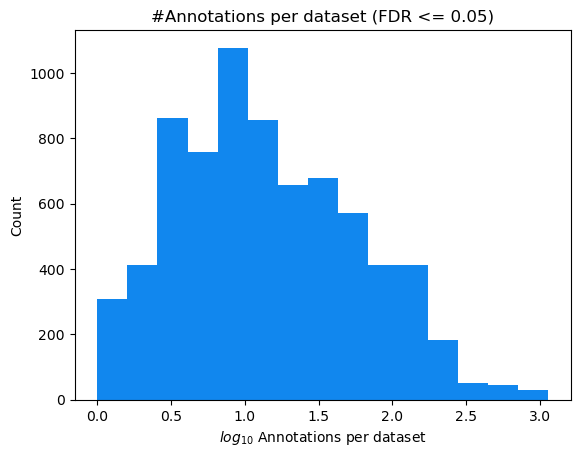

In [269]:
ax1 = sns.histplot(np.log10(apd(results, 0.05)), bins=15, color='#1187ee', alpha=1, edgecolor=None)
ax1.set_title(f"#Annotations per dataset (FDR <= {0.05})")
ax1.set_xlabel(r'$log_{10}$ Annotations per dataset')

## Datasets per annotation

Text(0.5, 0, '$log_{10}$ Datasets per annotation')

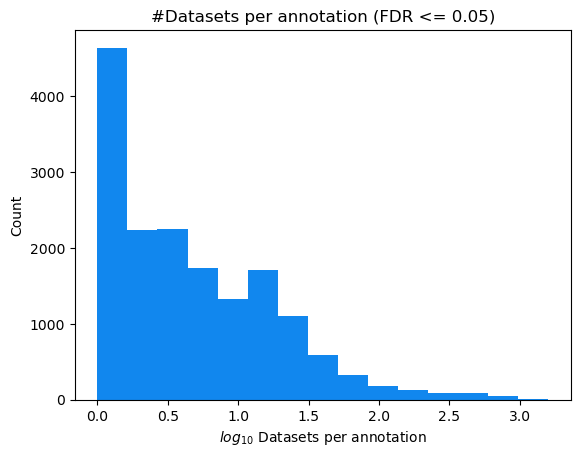

In [268]:
ax1 = sns.histplot(np.log10(list(dpa(results, 0.05).values())), bins=15, color='#1187ee', alpha=1, edgecolor=None)
ax1.set_title(f"#Datasets per annotation (FDR <= {0.05})")
ax1.set_xlabel(r'$log_{10}$ Datasets per annotation')

## Databases

In [281]:
dss[100].databases

['BraChemDB', 'HMDB', 'NPA', 'KEGG']

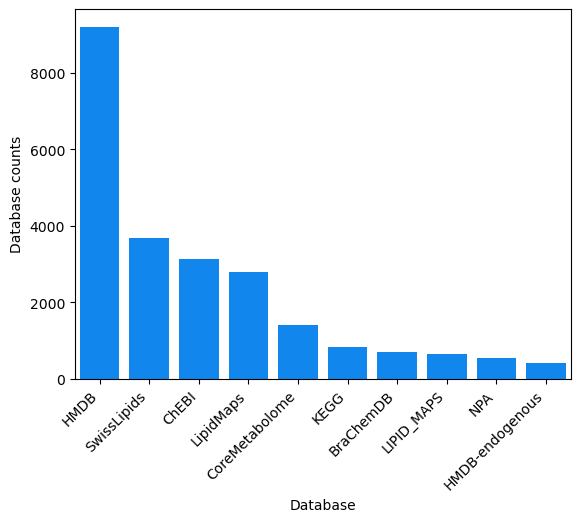

In [304]:
tmp = pd.DataFrame({'Database counts': pd.DataFrame({'Database': db}).value_counts()}).reset_index()[:10]
ax = sns.barplot(data=tmp, x='Database', y='Database counts', facecolor='#1187ee', alpha=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
plt.show()

# Figure 1 Suppl.

## Annotations per dataset

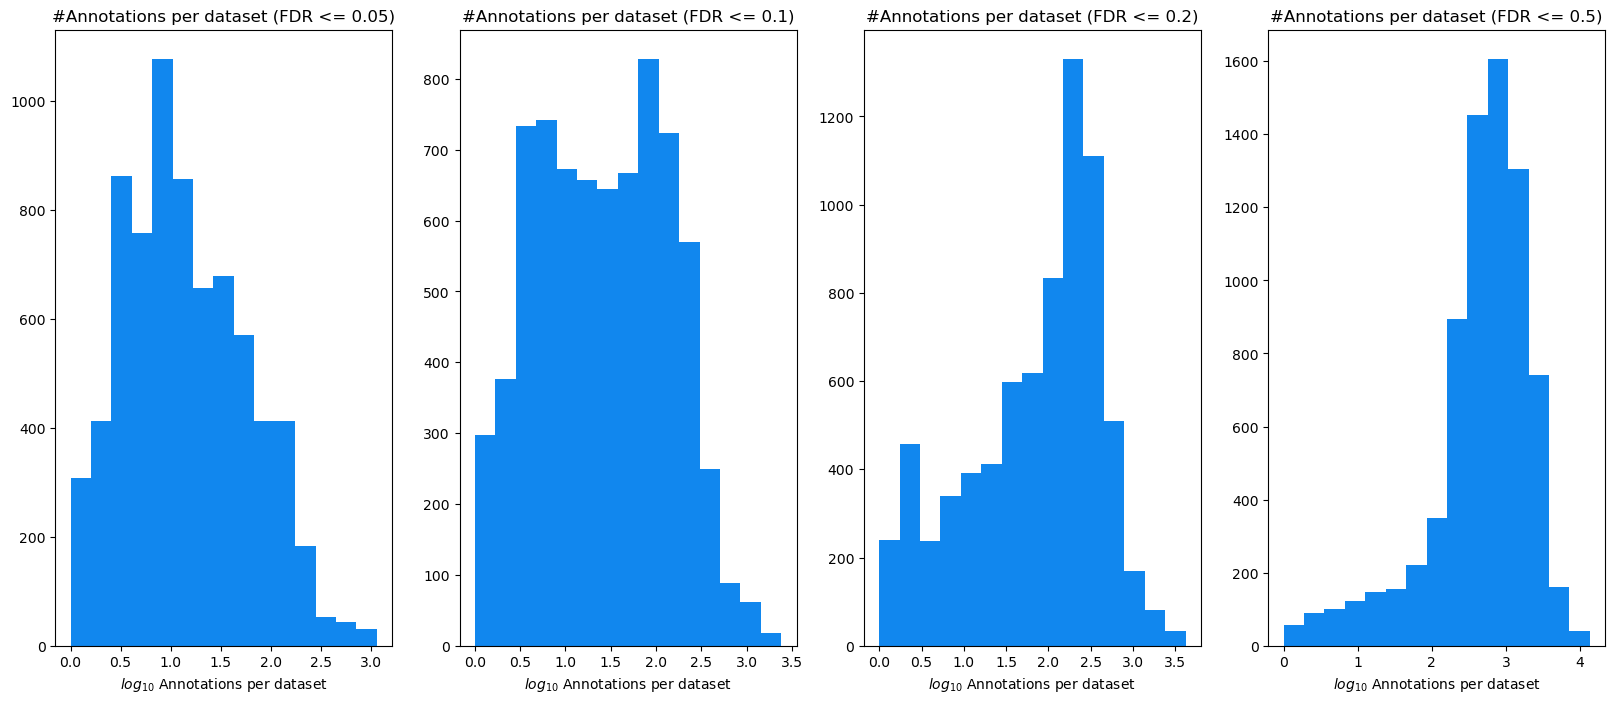

In [271]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 8))

ax1.hist(np.log10(apd(results, 0.05)), bins=15, color='#1187ee')
ax1.set_title(f"#Annotations per dataset (FDR <= {0.05})")
ax1.set_xlabel(r'$log_{10}$ Annotations per dataset')
         
ax2.hist(np.log10(apd(results, 0.1)), bins=15, color='#1187ee')
ax2.set_title(f"#Annotations per dataset (FDR <= {0.1})")
ax2.set_xlabel(r'$log_{10}$ Annotations per dataset')

ax3.hist(np.log10(apd(results, 0.2)), bins=15, color='#1187ee')
ax3.set_title(f"#Annotations per dataset (FDR <= {0.2})")
ax3.set_xlabel(r'$log_{10}$ Annotations per dataset')
         
ax4.hist(np.log10(apd(results, 0.5)), bins=15, color='#1187ee')
ax4.set_title(f"#Annotations per dataset (FDR <= {0.5})")
ax4.set_xlabel(r'$log_{10}$ Annotations per dataset')
plt.show()

## Datasets per annotation

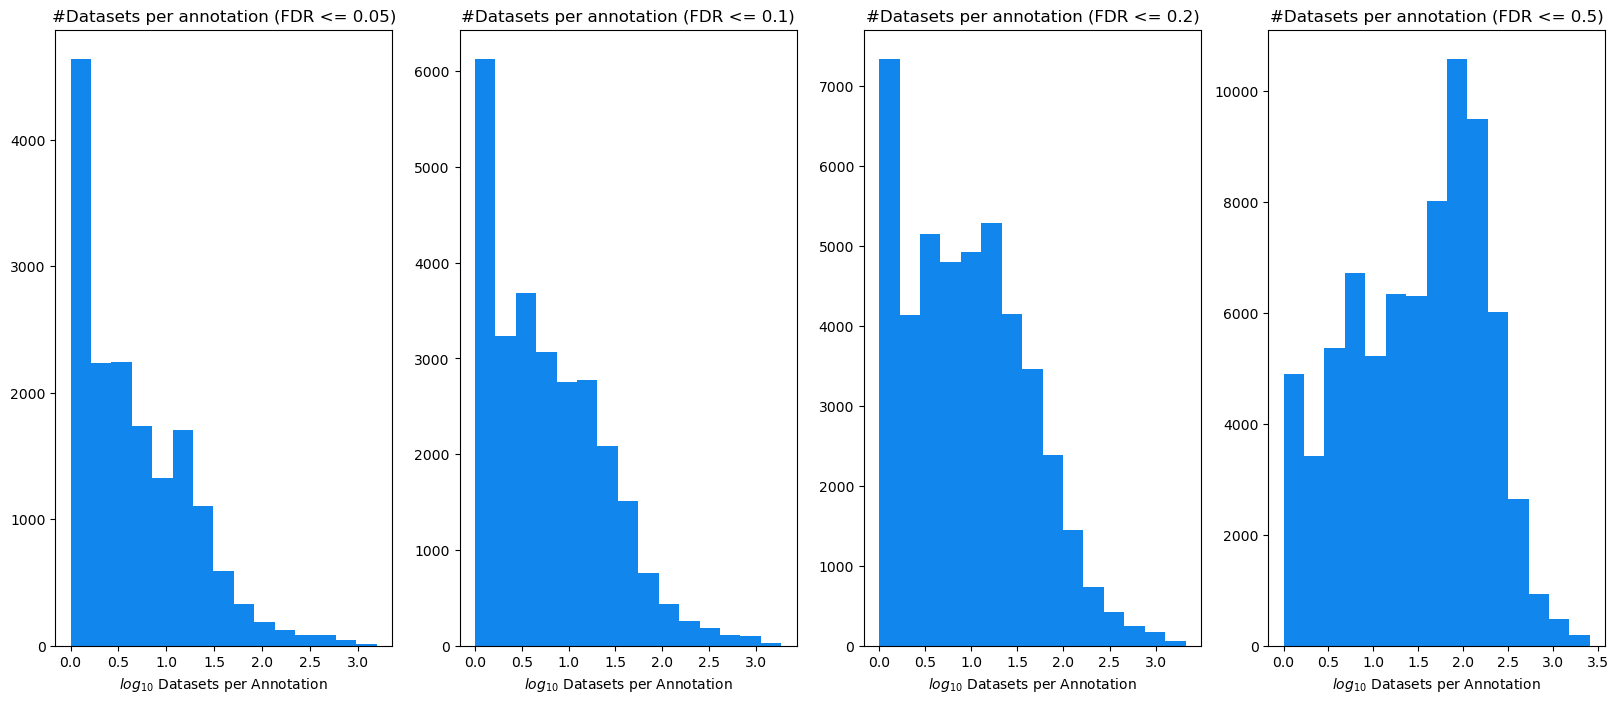

In [273]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 8))

ax1.hist(np.log10(list(dpa(results, 0.05).values())), bins=15, color='#1187ee')
ax1.set_title(f"#Datasets per annotation (FDR <= {0.05})")
ax1.set_xlabel(r'$log_{10}$ Datasets per Annotation')
         
ax2.hist(np.log10(list(dpa(results, 0.1).values())), bins=15, color='#1187ee')
ax2.set_title(f"#Datasets per annotation (FDR <= {0.1})")
ax2.set_xlabel(r'$log_{10}$ Datasets per Annotation')

ax3.hist(np.log10(list(dpa(results, 0.2).values())), bins=15, color='#1187ee')
ax3.set_title(f"#Datasets per annotation (FDR <= {0.2})")
ax3.set_xlabel(r'$log_{10}$ Datasets per Annotation')
         
ax4.hist(np.log10(list(dpa(results, 0.5).values())), bins=15, color='#1187ee')
ax4.set_title(f"#Datasets per annotation (FDR <= {0.5})")
ax4.set_xlabel(r'$log_{10}$ Datasets per Annotation')
plt.show()

## Dynamic range

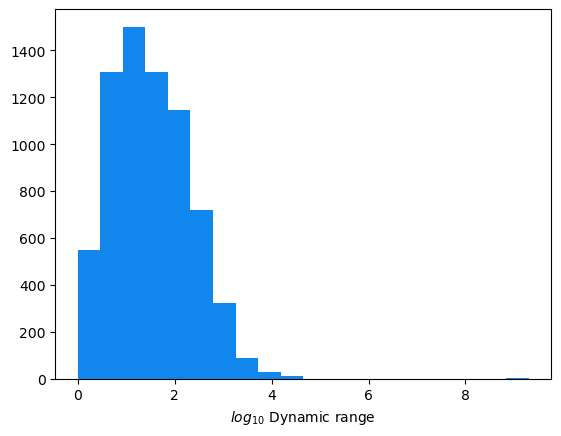

In [23]:
dynamic_range = np.array([results[x][results[x]['fdr']==0.05]['intensity'].max() / results[x][results[x]['fdr']==0.05]['intensity'].min() for x in results.keys()])
dynamic_range = dynamic_range[dynamic_range != 1]
plt.hist(np.log10(dynamic_range), bins=20, color='#1187ee')
plt.xlabel(r'$log_{10}$ Dynamic range')
plt.show()

## mz range

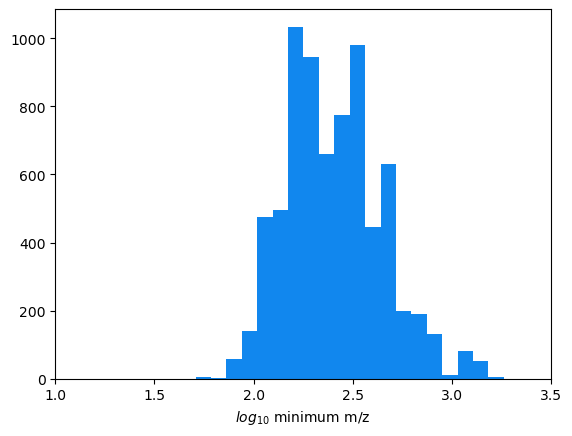

In [17]:
plt.hist(np.log10(mdt['mzmin']), bins=20, color='#1187ee')
plt.xlabel(r'$log_{10}$ minimum m/z')
plt.xlim((1, 3.5))
plt.show()

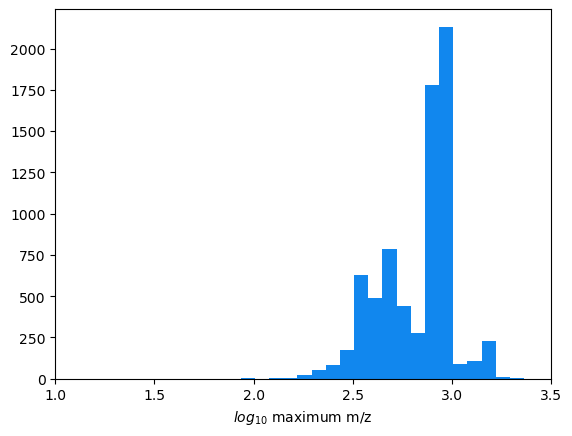

In [18]:
plt.hist(np.log10(mdt['mzmax']), bins=20, color='#1187ee')
plt.xlabel(r'$log_{10}$ maximum m/z')
plt.xlim((1, 3.5))
plt.show()

## Annotations over time

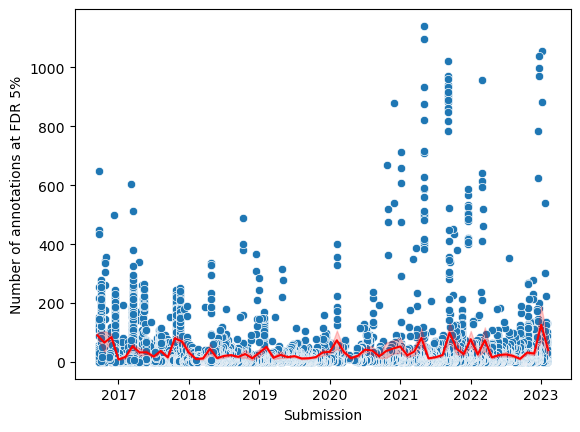

In [63]:
dat = []
anns = []
fdr_cutoff = 0.05

for key, ds in results.items():
    anns.append((ds['fdr']<= fdr_cutoff).sum())
    dat.append(toYearFraction(date.fromisoformat(key.split('_')[0])))
    
aotdf = pd.DataFrame({'Submission': dat, 'annotations': anns})
ax = sns.scatterplot(data=aotdf, x='Submission', y='annotations')

aotdf2 = aotdf.copy()
aotdf2['Submission']=(aotdf2['Submission'].round(1)*1e1).astype(int)
aotdf2 = aotdf2.set_index('Submission').rolling(1).median().reset_index()
aotdf2['Submission'] = aotdf2['Submission']/10 
sns.lineplot(data=aotdf2, x='Submission', y='annotations', ax=ax, color='red')
ax.set_ylabel('Number of annotations at FDR {:.0%}'.format(fdr_cutoff))
plt.show()

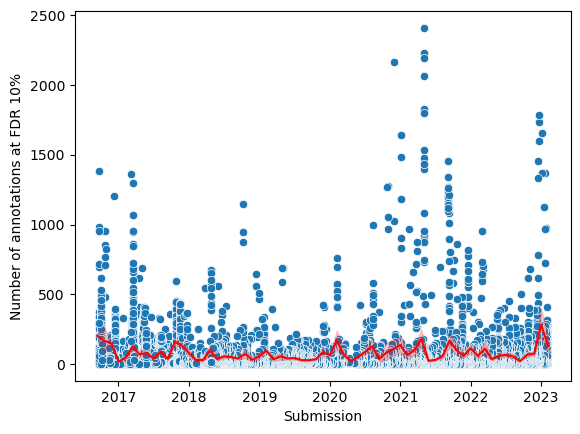

In [64]:
dat = []
anns = []
fdr_cutoff = 0.10

for key, ds in results.items():
    anns.append((ds['fdr']<= fdr_cutoff).sum())
    dat.append(toYearFraction(date.fromisoformat(key.split('_')[0])))
    
aotdf = pd.DataFrame({'Submission': dat, 'annotations': anns})
ax = sns.scatterplot(data=aotdf, x='Submission', y='annotations')

aotdf2 = aotdf.copy()
aotdf2['Submission']=(aotdf2['Submission'].round(1)*1e1).astype(int)
aotdf2 = aotdf2.set_index('Submission').rolling(1).median().reset_index()
aotdf2['Submission'] = aotdf2['Submission']/10 
sns.lineplot(data=aotdf2, x='Submission', y='annotations', ax=ax, color='red')
ax.set_ylabel('Number of annotations at FDR {:.0%}'.format(fdr_cutoff))
plt.show()

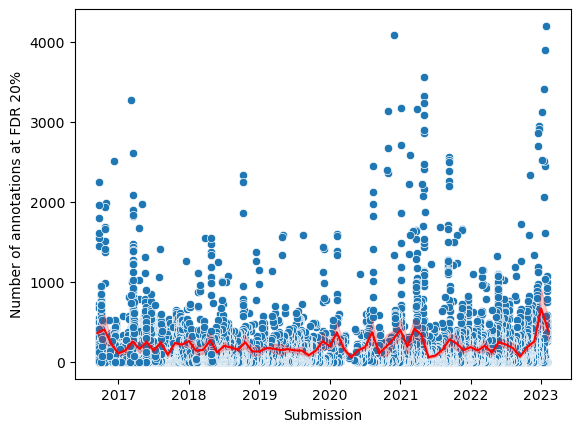

In [65]:
dat = []
anns = []
fdr_cutoff = 0.20

for key, ds in results.items():
    anns.append((ds['fdr']<= fdr_cutoff).sum())
    dat.append(toYearFraction(date.fromisoformat(key.split('_')[0])))
    
aotdf = pd.DataFrame({'Submission': dat, 'annotations': anns})
ax = sns.scatterplot(data=aotdf, x='Submission', y='annotations')

aotdf2 = aotdf.copy()
aotdf2['Submission']=(aotdf2['Submission'].round(1)*1e1).astype(int)
aotdf2 = aotdf2.set_index('Submission').rolling(1).median().reset_index()
aotdf2['Submission'] = aotdf2['Submission']/10 
sns.lineplot(data=aotdf2, x='Submission', y='annotations', ax=ax, color='red')
ax.set_ylabel('Number of annotations at FDR {:.0%}'.format(fdr_cutoff))
plt.show()

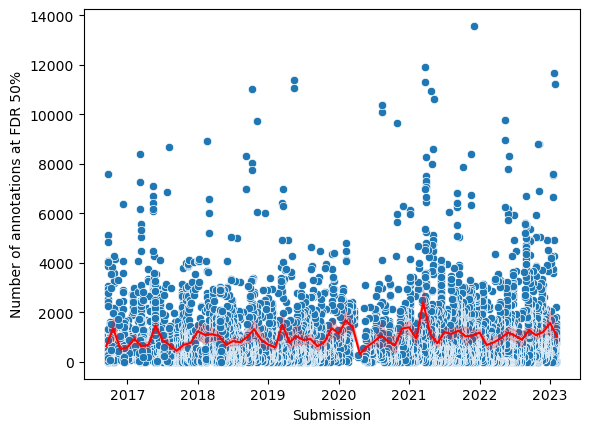

In [66]:
dat = []
anns = []
fdr_cutoff = 0.5

for key, ds in results.items():
    anns.append((ds['fdr']<= fdr_cutoff).sum())
    dat.append(toYearFraction(date.fromisoformat(key.split('_')[0])))
    
aotdf = pd.DataFrame({'Submission': dat, 'annotations': anns})
ax = sns.scatterplot(data=aotdf, x='Submission', y='annotations')

aotdf2 = aotdf.copy()
aotdf2['Submission']=(aotdf2['Submission'].round(1)*1e1).astype(int)
aotdf2 = aotdf2.set_index('Submission').rolling(1).median().reset_index()
aotdf2['Submission'] = aotdf2['Submission']/10 
sns.lineplot(data=aotdf2, x='Submission', y='annotations', ax=ax, color='red')
ax.set_ylabel('Number of annotations at FDR {:.0%}'.format(fdr_cutoff))
plt.show()

# Old plots

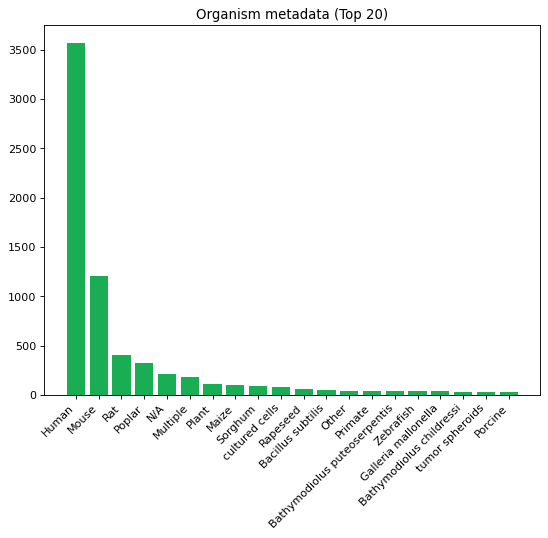

In [6]:
col = 'Organism'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#1aae54')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

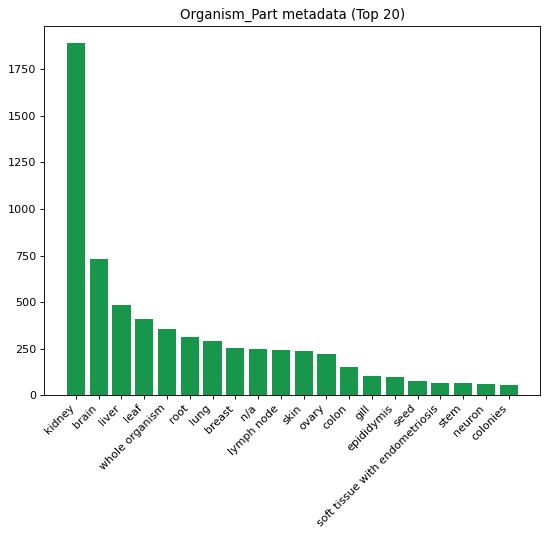

In [33]:
col = 'Organism_Part'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#1aae54')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

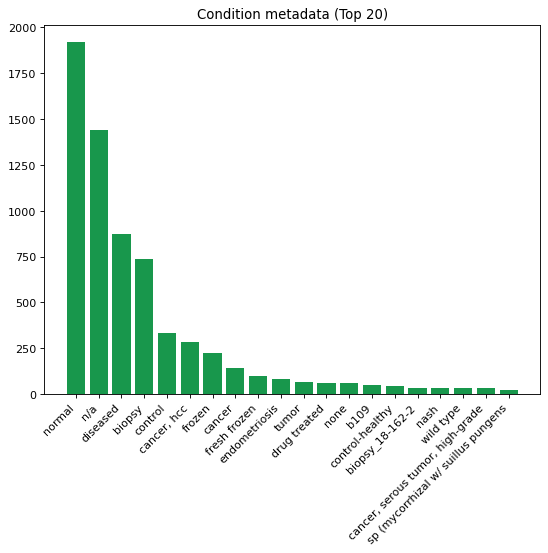

In [34]:
col = 'Condition'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#1aae54')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

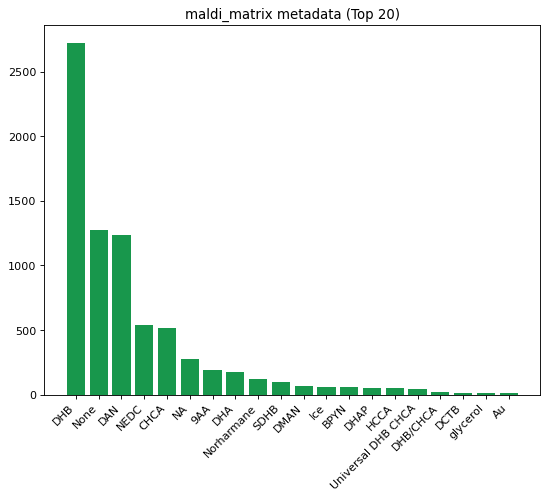

In [53]:
col = 'maldi_matrix'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#1aae54')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

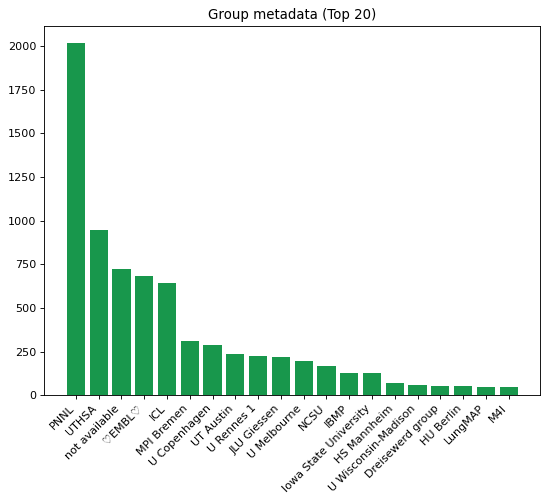

In [54]:
col = 'Group'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#1aae54')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

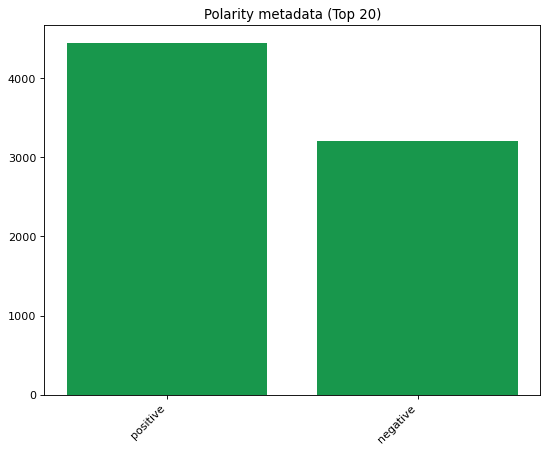

In [61]:
col = 'Polarity'
tmp = pd.value_counts(mdt[col])[0:20]
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(tmp)), list(tmp.values), align='center', color='#1aae54')
plt.xticks(range(len(tmp)), list(tmp.index), rotation = 45, ha='right')
plt.title(col + ' metadata (Top 20)')
plt.show()

<AxesSubplot: xlabel='mzmin', ylabel='Count'>

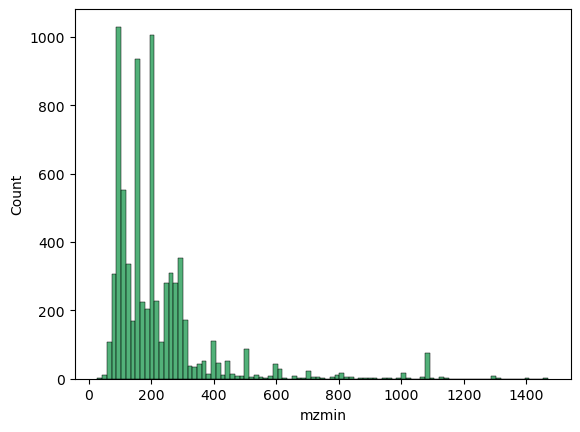

In [57]:
sns.histplot(data=mdt, x='mzmin', color='#1aae54')

<AxesSubplot: xlabel='mzmax', ylabel='Count'>

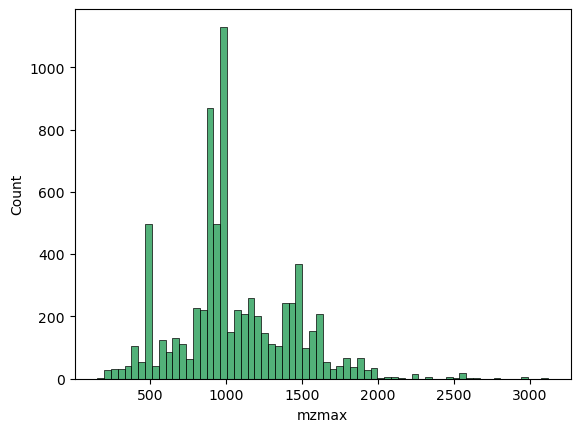

In [58]:
sns.histplot(data=mdt, x='mzmax', color='#1aae54')

<AxesSubplot: xlabel='mzrange', ylabel='Count'>

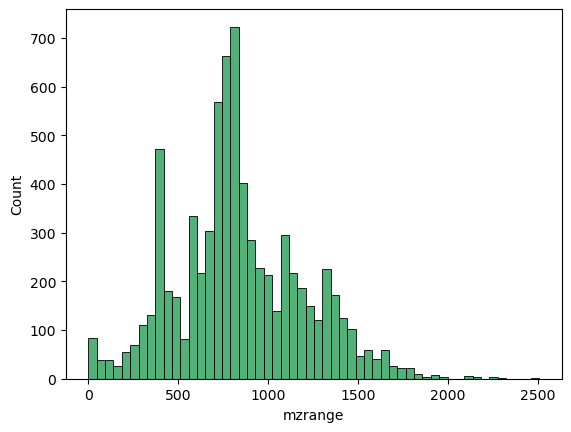

In [60]:
mdt['mzrange'] = mdt['mzmax'] - mdt['mzmin']
sns.histplot(data=mdt, x='mzrange', color='#18974C')

# Database statistics

# Annotation statistics

## Annotations over time

/tmp/ipykernel_89/1469122220.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right')


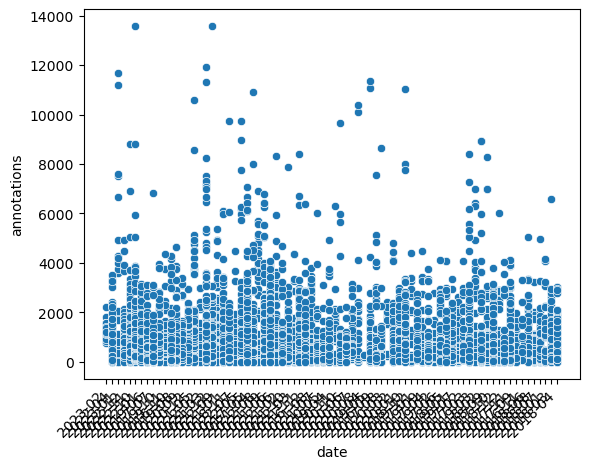

In [38]:
time_l = []
ann_t = []
for k, v in results.items():
    time_l.append('-'.join(k.split('-')[:2]))
    ann_t.append(v.shape[0])

time_df = pd.DataFrame({'annotations': ann_t, 'date': time_l})

plot = sns.scatterplot(data=time_df, x='date', y='annotations')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [28]:
time_df

,annotations,date
0,1167,202302
1,1065,202302
2,1428,202302
3,1158,202302
4,992,202302
...,...,...
7438,135,201804
7439,8,201805
7440,1400,201804
7441,1660,201804


## Annotations per dataset

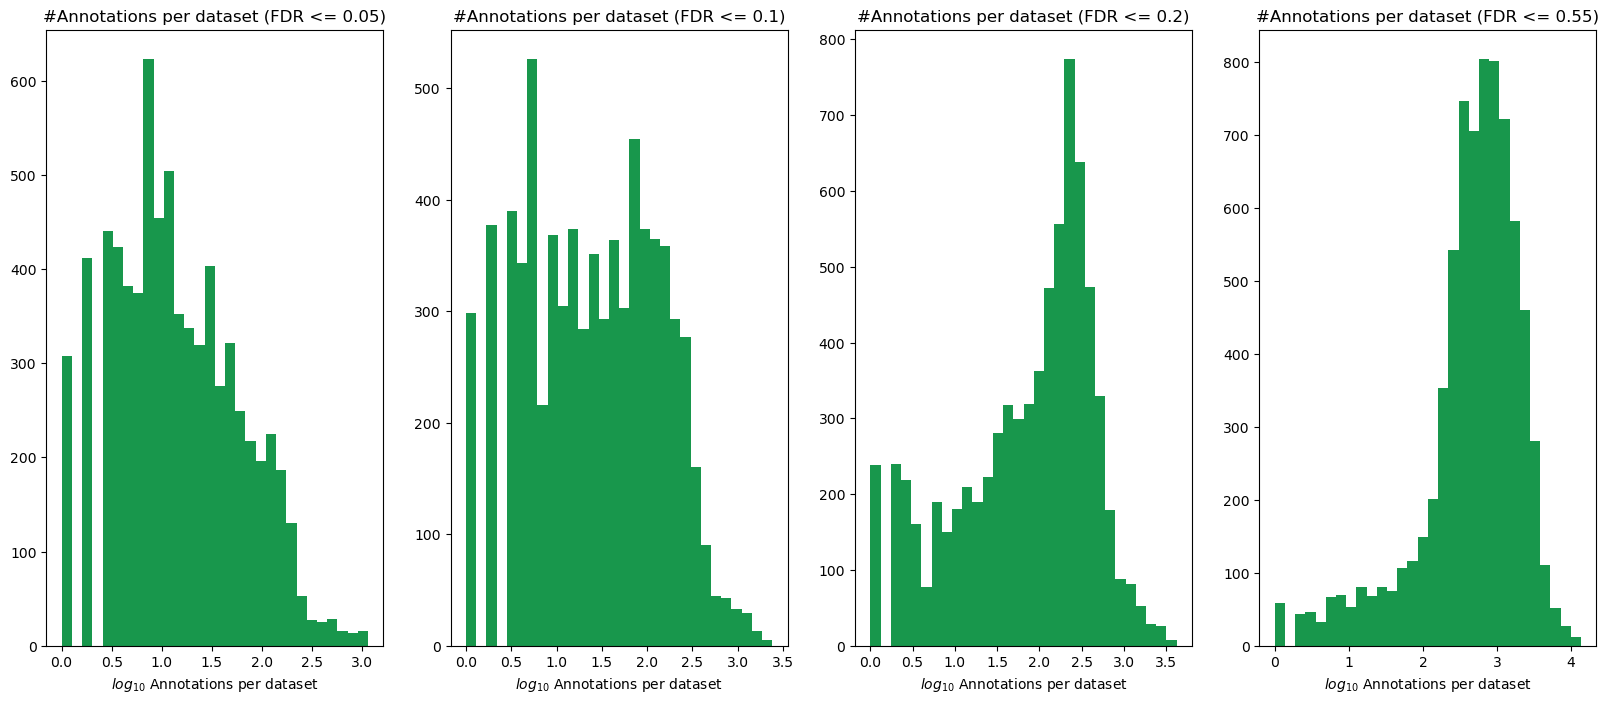

In [5]:
def apd(results, fdr_cutoff=0.05):
    n_anno = []
    for tab in results.values():
        if tab[tab['fdr'] <= fdr_cutoff].shape[0] >0:
            n_anno.append(tab[tab['fdr'] <= fdr_cutoff].shape[0])
            
    return n_anno

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 8))

ax1.hist(np.log10(apd(results, 0.05)), bins=30, color='#18974C')
ax1.set_title(f"#Annotations per dataset (FDR <= {0.05})")
ax1.set_xlabel(r'$log_{10}$ Annotations per dataset')
         
ax2.hist(np.log10(apd(results, 0.1)), bins=30, color='#18974C')
ax2.set_title(f"#Annotations per dataset (FDR <= {0.1})")
ax2.set_xlabel(r'$log_{10}$ Annotations per dataset')

ax3.hist(np.log10(apd(results, 0.2)), bins=30, color='#18974C')
ax3.set_title(f"#Annotations per dataset (FDR <= {0.2})")
ax3.set_xlabel(r'$log_{10}$ Annotations per dataset')
         
ax4.hist(np.log10(apd(results, 0.5)), bins=30, color='#18974C')
ax4.set_title(f"#Annotations per dataset (FDR <= {0.5})")
ax4.set_xlabel(r'$log_{10}$ Annotations per dataset')
plt.show()

## Datasets per annotation

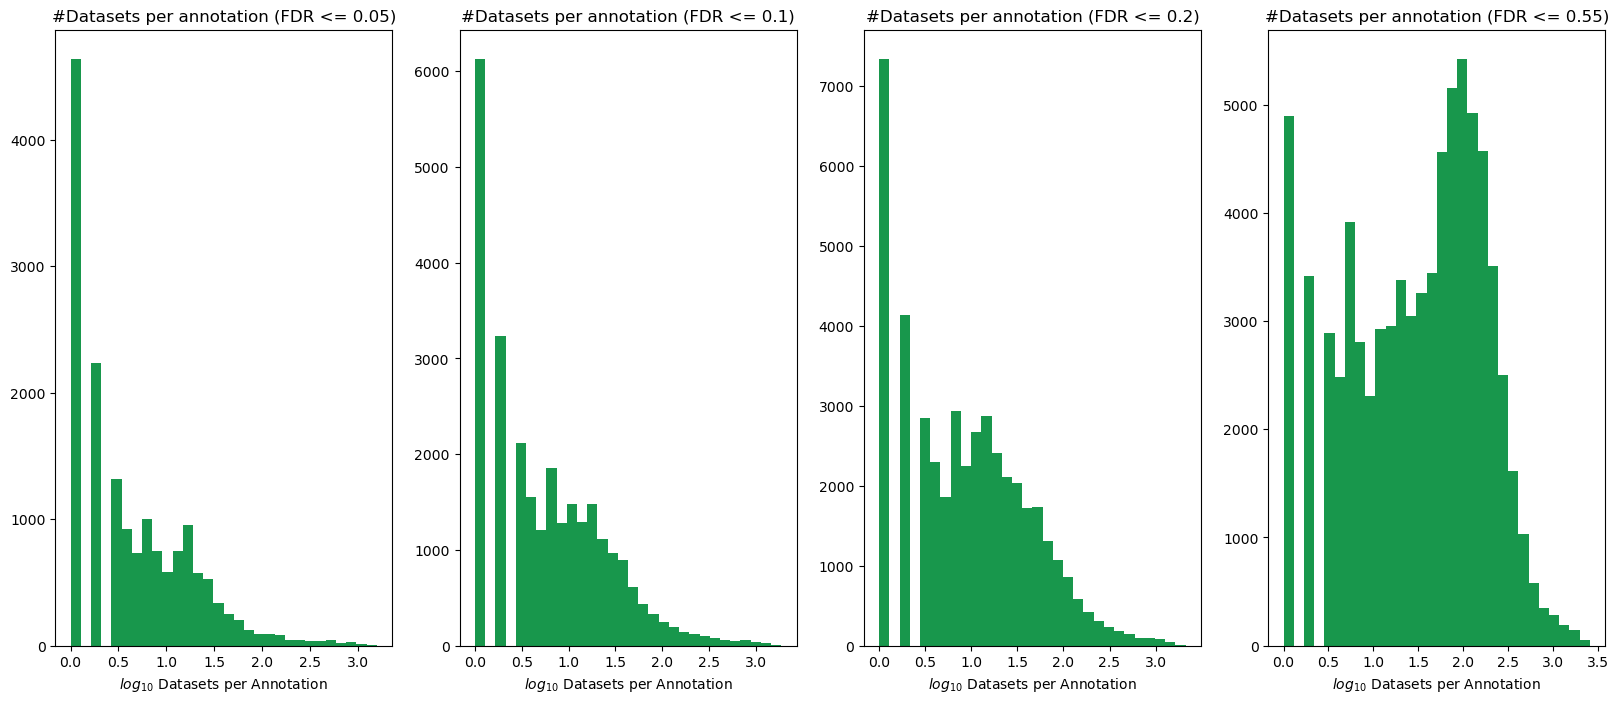

In [82]:
def dpa(results, fdr_cutoff=0.05):
    dpad = defaultdict(int)
    for tab in results.values():
        tmp = list(tab[tab['fdr'] <= fdr_cutoff].index)
        for t in tmp:
            dpad[t] += 1
    return dpad

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 8))

ax1.hist(np.log10(list(dpa(results, 0.05).values())), bins=30, color='#18974C')
ax1.set_title(f"#Datasets per annotation (FDR <= {0.05})")
ax1.set_xlabel(r'$log_{10}$ Datasets per Annotation')
         
ax2.hist(np.log10(list(dpa(results, 0.1).values())), bins=30, color='#18974C')
ax2.set_title(f"#Datasets per annotation (FDR <= {0.1})")
ax2.set_xlabel(r'$log_{10}$ Datasets per Annotation')

ax3.hist(np.log10(list(dpa(results, 0.2).values())), bins=30, color='#18974C')
ax3.set_title(f"#Datasets per annotation (FDR <= {0.2})")
ax3.set_xlabel(r'$log_{10}$ Datasets per Annotation')
         
ax4.hist(np.log10(list(dpa(results, 0.5).values())), bins=30, color='#18974C')
ax4.set_title(f"#Datasets per annotation (FDR <= {0.55})")
ax4.set_xlabel(r'$log_{10}$ Datasets per Annotation')
plt.show()

# Metabolite class statistics

In [87]:
hmdb4_metclasses = pd.read_csv(os.path.join(data_dir, 'databases', 'HMDB_v4.csv'))

In [89]:
super_class_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses.super_class))
class_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses['class']))
sub_class_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses.sub_class))
status_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses.status))

In [90]:

# For each dataset, make a list of lists with HMDB accessions
fdr_cutoff = 0.1

metaspace_annotation_super_class = {}
metaspace_annotation_class = {}
metaspace_annotation_sub_class = {}

for i in tqdm(results.keys()):
    # Get all moleculeids:
    tmp_ids = list(results[i][results[i]['fdr'] <= fdr_cutoff]['moleculeIds'])
    
    metaspace_annotation_super_class[i] = []
    metaspace_annotation_class[i] = []
    metaspace_annotation_sub_class[i] = []
    for io in tmp_ids:
        ion = ast.literal_eval(io)
        if (len(ion)) == 1:
            if ion[0] in super_class_dict.keys():
                metaspace_annotation_super_class[i].append([super_class_dict[ion[0]]])
                metaspace_annotation_class[i].append([class_dict[ion[0]]])
                metaspace_annotation_sub_class[i].append([sub_class_dict[ion[0]]])
        else:
            tmp_super_class = []
            tmp_class = []
            tmp_sub_class = []
            for ann in ion:
                if status_dict.get(ann, 'not found') == 'quantified' or status_dict.get(ann, 'not found') == 'detected':
                    tmp_super_class.append(super_class_dict[ann])
                    tmp_class.append(class_dict[ann])
                    tmp_sub_class.append(sub_class_dict[ann])
            if len(tmp_super_class)>0: metaspace_annotation_super_class[i].append(tmp_super_class)
            if len(tmp_class)>0: metaspace_annotation_class[i].append(tmp_class)
            if len(tmp_sub_class)>0: metaspace_annotation_sub_class[i].append(tmp_sub_class)

  0%|          | 0/7443 [00:00<?, ?it/s]


KeyError: 'moleculeIds'

In [ ]:
tmp_dict = metaspace_annotation_super_class
cd = defaultdict(int)
for key, val in tmp_dict.items():
    tmp_classes = list(set(utils.flatten(val)))
    for it in tmp_classes:
        cd[it] += 1
cd=dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMCB super-class at least once per dataset')
plt.show()

In [ ]:
tmp_dict = metaspace_annotation_class
cd = defaultdict(int)
for key, val in tmp_dict.items():
    tmp_classes = list(set(utils.flatten(val)))
    for it in tmp_classes:
        cd[it] += 1
cd=dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd= {list(cd.keys())[i]: list(cd.values())[i] for i in range(20)}
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMCB class at least once per dataset')
plt.show()

In [ ]:
tmp_dict = metaspace_annotation_sub_class
cd = defaultdict(int)
for key, val in tmp_dict.items():
    tmp_classes = list(set(utils.flatten(val)))
    for it in tmp_classes:
        cd[it] += 1
cd=dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd= {list(cd.keys())[i]: list(cd.values())[i] for i in range(20)}
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMDB sub-class at least once per dataset')
plt.show()

## Frequency of terms in datasets

In [ ]:
tmp_dict = metaspace_annotation_super_class
cd = defaultdict(float)
tmp_l = []
for key, val in tmp_dict.items():
    tmp_classes = [random.choice(x) for x in val]
    tmp_dict = defaultdict(int)
    for it in tmp_classes:
        tmp_dict[it] += 1
    tmp_dict = {key: val/sum(tmp_dict.values()) for key, val in tmp_dict.items()}
    for k2, v2 in tmp_dict.items():
        cd[k2] += v2
cd = {key: val/sum(cd.values()) for key, val in cd.items()}
cd = dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd = {list(cd.keys())[i]: list(cd.values())[i] for i in range(20)}
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMDB super-class frequency per dataset (if present)')
plt.show()

In [ ]:
tmp_dict = metaspace_annotation_class
cd = defaultdict(float)
tmp_l = []
for key, val in tmp_dict.items():
    tmp_classes = [random.choice(x) for x in val]
    tmp_dict = defaultdict(int)
    for it in tmp_classes:
        tmp_dict[it] += 1
    tmp_dict = {key: val/sum(tmp_dict.values()) for key, val in tmp_dict.items()}
    for k2, v2 in tmp_dict.items():
        cd[k2] += v2
cd = {key: val/sum(cd.values()) for key, val in cd.items()}
cd = dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd = {list(cd.keys())[i]: list(cd.values())[i] for i in range(20)}
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMDB class frequency per dataset (if present)')
plt.show()

In [ ]:
tmp_dict = metaspace_annotation_sub_class
cd = defaultdict(float)
tmp_l = []
for key, val in tmp_dict.items():
    tmp_classes = [random.choice(x) for x in val]
    tmp_dict = defaultdict(int)
    for it in tmp_classes:
        tmp_dict[it] += 1
    tmp_dict = {key: val/sum(tmp_dict.values()) for key, val in tmp_dict.items()}
    for k2, v2 in tmp_dict.items():
        cd[k2] += v2
cd = {key: val/sum(cd.values()) for key, val in cd.items()}
cd = dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd = {list(cd.keys())[i]: list(cd.values())[i] for i in range(20)}
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(len(cd)), list(cd.values()), align='center', color='#18974C')
plt.xticks(range(len(cd)), list(cd.keys()), rotation = 45, ha='right')
plt.title('HMDB sub-class frequency per dataset (if present)')
plt.show()